# Instalación del programa en python

In [ ]:
# Install dependencies
%pip install -q amplpy pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 15.2 MB/s eta 0:00:00


### Google colab & Kaggle integration

In [ ]:
from amplpy import AMPL, ampl_notebook

ampl = ampl_notebook(
    modules=["highs", "cbc", "gurobi"],  # modules to install
    license_uuid="default",  # license to use
)  # instantiate AMPL object and register magics

Trabajos

# Modelo 1 Navidad

In [ ]:
%%ampl_eval
reset; # clear previous definitions
# define the set of people
set PEOPLE;

# define the set of gifts
set GIFTS;

# define the cost of each gift
param cost{GIFTS};

# define the happiness level for each person receiving each gift
param happiness{PEOPLE, GIFTS};

# define the budget for gift-giving
param budget;

# define the decision variables:
# x[p,g] is 1 if person p receives gift g, 0 otherwise
var x{PEOPLE, GIFTS} binary;

# the objective is to maximize total happiness
maximize total_happiness: sum{p in PEOPLE, g in GIFTS} happiness[p,g] * x[p,g];

# subject to the budget constraint:
# the total cost of the gifts must be less than or equal to the budget
subject to budget_constraint: sum{p in PEOPLE, g in GIFTS} cost[g] * x[p,g] <= budget;

# each person can only receive one gift
subject to one_gift_per_person{p in PEOPLE}: sum{g in GIFTS} x[p,g] = 1;

In [ ]:
ampl.set["PEOPLE"] = ["Alice", "Bob", "Carol", "Dave", "Eve"]
ampl.set["GIFTS"] = ["Book", "Toy", "Chocolate", "Wine", "Flowers"]
ampl.param["cost"] = {"Book": 10, "Toy": 20, "Chocolate": 5, "Wine": 15, "Flowers": 7}
ampl.param["budget"] = 50

In [ ]:
import pandas as pd

happiness_df = pd.DataFrame(
    {
        "Book": [3, 2, 5, 1, 4],
        "Toy": [5, 2, 4, 3, 1],
        "Chocolate": [1, 3, 4, 5, 2],
        "Wine": [2, 5, 3, 4, 1],
        "Flowers": [4, 3, 1, 2, 5],
    },
    index=["Alice", "Bob", "Carol", "Dave", "Eve"],
)

# To load the data for the parameter happiness you can use either happiness_df or happiness_df_stacked in the same way
ampl.param["happiness"] = happiness_df

toys_df = pd.DataFrame({ "Cost" : dict(ampl.param["cost"]).values()},
                       index = dict(ampl.param["cost"]).keys())

display(happiness_df)  # display 2D Pandas DataFrame
display(toys_df)  # display 2D Pandas DataFrame

,Book,Toy,Chocolate,Wine,Flowers
Alice,3,5,1,2,4
Bob,2,2,3,5,3
Carol,5,4,4,3,1
Dave,1,3,5,4,2
Eve,4,1,2,1,5


,Cost
Book,10
Chocolate,5
Flowers,7
Toy,20
Wine,15


### Solving with HIGHS

In [ ]:
ampl.option["solver"] = "highs"
ampl.solve()

solution = ampl.get_data("{p in PEOPLE, g in GIFTS: x[p, g] > 0} x[p, g]").to_dict()
print(f"Solution:\n\t{solution}")

print("\nTo maximize the total happiness:")
for person, gift in solution:
    print(f"- give {gift} to {person}.")

HiGHS 1.6.0: HiGHS 1.6.0: optimal solution; objective 24
3 simplex iterations
1 branching nodes
Solution:
	{('Alice', 'Flowers'): 1, ('Bob', 'Wine'): 1, ('Carol', 'Book'): 1, ('Dave', 'Chocolate'): 1, ('Eve', 'Flowers'): 1}

To maximize the total happiness:
- give Flowers to Alice.
- give Wine to Bob.
- give Book to Carol.
- give Chocolate to Dave.
- give Flowers to Eve.


### Change the Budget and solved with gurobi

In [ ]:
ampl.param["budget"] = 100
ampl.option["solver"] = "gurobi"
ampl.solve()

solution = ampl.var["x"].to_pandas()  # retrieve variable values as a Pandas DataFrame
print("Solution:")
display(solution[solution["x.val"] == 1])  # display rows with x.val == 1

print("\nTo maximize the total happiness:")
for person, gift in solution.index[solution["x.val"] == 1].tolist():
    print(f"- give {gift} to {person}.")

Gurobi 11.0.0: Gurobi 11.0.0: optimal solution; objective 25
0 simplex iteration(s)
Solution:


,,x.val
index0,index1,
Alice,Toy,1
Bob,Wine,1
Carol,Book,1
Dave,Chocolate,1
Eve,Flowers,1



To maximize the total happiness:
- give Toy to Alice.
- give Wine to Bob.
- give Book to Carol.
- give Chocolate to Dave.
- give Flowers to Eve.


### Change the Budget and solved with cbc


In [ ]:
ampl.param["budget"] = 30
ampl.option["solver"] = "cbc"
ampl.solve()

solution = ampl.var["x"].to_dict()  # retrieve variable values as a dictionary
print(f"Solution:\n\t{solution}")

print("\nTo maximize the total happiness:")
for person, gift in solution:
    if solution[person, gift] == 1:
        print(f"- give {gift} to {person}.")

cbc 2.10.10: cbc 2.10.10: optimal solution; objective 21
0 simplex iterations
Solution:
	{('Alice', 'Book'): 0, ('Alice', 'Chocolate'): 0, ('Alice', 'Flowers'): 1, ('Alice', 'Toy'): 0, ('Alice', 'Wine'): 0, ('Bob', 'Book'): 0, ('Bob', 'Chocolate'): 1, ('Bob', 'Flowers'): 0, ('Bob', 'Toy'): 0, ('Bob', 'Wine'): 0, ('Carol', 'Book'): 0, ('Carol', 'Chocolate'): 1, ('Carol', 'Flowers'): 0, ('Carol', 'Toy'): 0, ('Carol', 'Wine'): 0, ('Dave', 'Book'): 0, ('Dave', 'Chocolate'): 1, ('Dave', 'Flowers'): 0, ('Dave', 'Toy'): 0, ('Dave', 'Wine'): 0, ('Eve', 'Book'): 0, ('Eve', 'Chocolate'): 0, ('Eve', 'Flowers'): 1, ('Eve', 'Toy'): 0, ('Eve', 'Wine'): 0}

To maximize the total happiness:
- give Flowers to Alice.
- give Chocolate to Bob.
- give Chocolate to Carol.
- give Chocolate to Dave.
- give Flowers to Eve.


# Actividad en Clases

## Problema de Programación Personasl

Union Airways va a agregar vuelos desde y hacia su
aeropuerto base, y por lo tanto necesita contratar más
agentes de servicio al cliente. Sin embargo, no está
claro cuantos más debe contratar.
La administración reconoce la necesidad de controlar el
costo y al mismo tiempo brindar un nivel de atención
satisfactorio.
Se ha realizado un análisis del número mínimo de agentes
de servicio que deben encontrarse de guardia en
diferente momentos del día para proporcionar un nivel
satisfactorio de servicio.

Se ha acordado que cada agente trabaje un turno de 8
horas, 5 días a la semana en los turnos mostrados en la
siguiente diapositiva.
Los salarios de cada turno son diferentes debido a que unos
son más deseables que otros.
La compañía debe determinar cuántos agentes deben
asignarse a los turnos respectivos cada día para minimizar
el costo total del personal, debido a los agentes, según el
último renglón de la tabla anterior. Los requerimientos
mínimos de servicio deben cumplirse obligatoriamente, pero
pueden sobrepasarse.

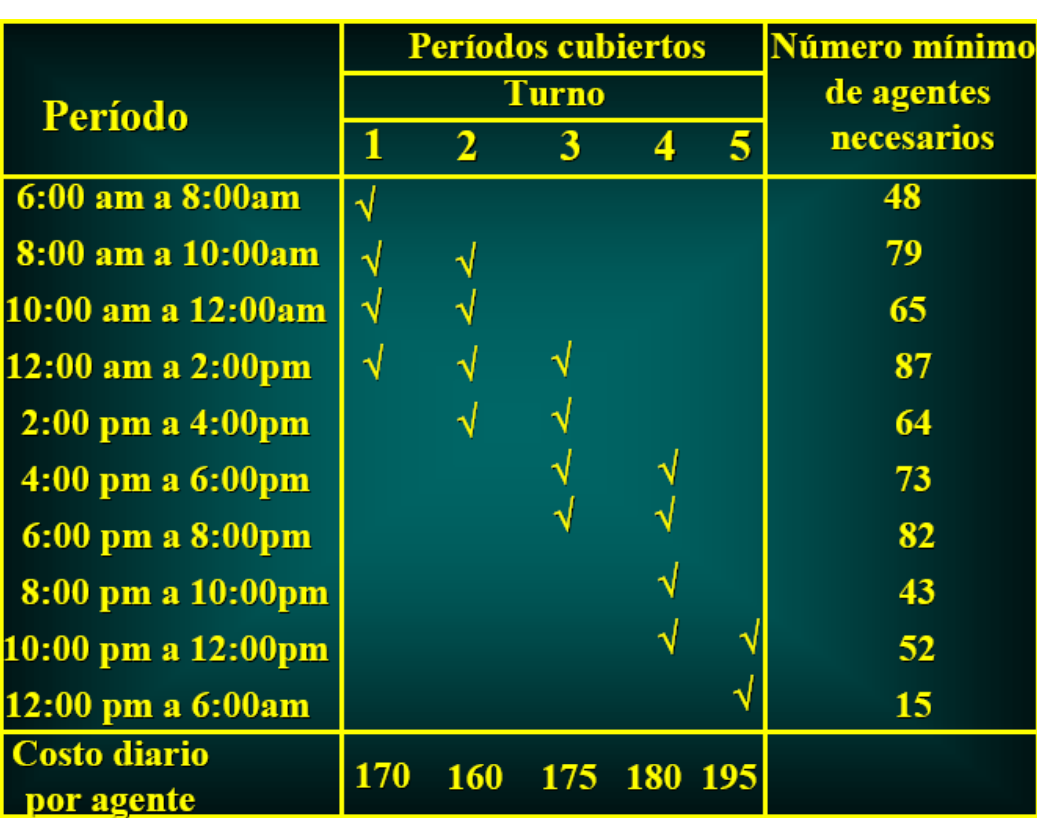

### Definición del Modelo

**Conjuntos**:

*   FRANJAS
*   TURNOS

**Parametros**

*   costo_per_turno{TURNOS}
*   numero_de_agente_per_franja{FRANJAS}
*   solapamiento_de_turno_franja{TURNOS, FRANJAS}

**Variables**

*   cant_gente_per_turno{TURNOS}

**Función objetivo**


*   Minimizar el costo de contratación
*   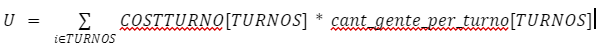



**Restricciones**

*   Se debe cumplir la cantidad de gente por franja horaria
*   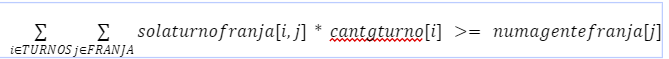




### Definición

In [ ]:
%%ampl_eval
reset; # clear previous definitions
# define the setS

set TURNOS;
set FRANJAS;

# define parameters

param cost_turn{TURNOS}; #Costo por turno
param num_agent_franj{FRANJAS}; #Cantidad de agentes requeriods por franja
param solap_turn_franj{TURNOS, FRANJAS}; #En que franja estan activos los turnos

#define variables

var cant_gente_turno{TURNOS} >= 0 integer; #Cantidad de gente

#define objecive

# minimizar la cantidad de dinero al producir los materiales
minimize total_cost: sum{turn in TURNOS} cant_gente_turno[turn]*cost_turn[turn];

#define constraints
#la suma de las minas por materiales debe ser mayor o igual a lo solicitado
subject to contraints_de_agentes_por_turno {fran in FRANJAS}: sum{turn in TURNOS} solap_turn_franj[turn, fran] * cant_gente_turno[turn] >= num_agent_franj[fran];

### Declaración de parametros

In [ ]:
import pandas as pd

#Data

turnos = [1, 2, 3, 4, 5]
costo = [170, 160, 175, 180, 195]
llaves = ["6am-8am", "8am-10am", "10am-12pm", "12pm-2pm", "2pm-4pm", "4pm-6pm", "6pm-8pm", "8pm-10pm", "10pm-12am", "12am-6am"]
valores = [48, 79, 65, 87, 64, 73, 82, 43, 52, 15]

ampl.set["TURNOS"] = turnos
ampl.set["FRANJAS"] = llaves

temp = dict()
for i in range(len(turnos)):
  temp[turnos[i]] = costo[i]

ampl.param["cost_turn"] = temp

temp = dict()
for i in range(len(llaves)):
  temp[llaves[i]] = valores[i]

ampl.param["num_agent_franj"] = temp

array = [[1, 0, 0, 0, 0],
         [1, 1, 0, 0, 0],
         [1, 1, 0, 0, 0],
         [1, 1, 1, 0, 0],
         [0, 1, 1, 0, 0],
         [0, 0, 1, 1, 0],
         [0, 0, 1, 1, 0],
         [0, 0, 0, 1, 0],
         [0, 0, 0, 1, 1],
         [0, 0, 0, 0, 1]]

for i in range(len(llaves)):
  temp[llaves[i]] = array[i]

mat_prod_df = pd.DataFrame(
    temp,
    index=list(ampl.set["TURNOS"]),
)

ampl.param["solap_turn_franj"] = mat_prod_df

### Solución

In [ ]:
ampl.option["solver"] = "gurobi"
ampl.solve()

solution = ampl.get_data("{t in TURNOS: cant_gente_turno[t] >= 0} cant_gente_turno[t]").to_dict()||

print("\nTo minimize the total cost:")
for key in solution:
    print(f"- give Turn {key}, people {solution[key]}.")

Gurobi 11.0.0: Gurobi 11.0.0: optimal solution; objective 30610
0 simplex iteration(s)
{1: 48, 2: 31, 3: 39, 4: 43, 5: 15}

To minimize the total cost:
- give Turn 1, people 48.
- give Turn 2, people 31.
- give Turn 3, people 39.
- give Turn 4, people 43.
- give Turn 5, people 15.


# Modelos Ejercicios Propuestos

## Modelo 2


Una compañía de alquiler de camiones dispone de dos tipos de vehículos: el tipo A que posee 20 pies cúbicos de espacio refrigerado y 40 pies cúbico de espacio no refrigerado; el tipo B que posee 30 pies cúbicos de espacio refrigerado y la misma cantidad de espacio no refrigerado. Una fábrica de alimentos debe transportar 900 pies cúbicos de producto refrigerado y 1200 pies cúbicos de producto no refrigerado. Cuantos camiones de cada tipo se deben alquilar, si el camión A se alquila a \$30 por milla y el camión B a \$40 por milla?

In [ ]:
%%ampl_eval
reset; # clear previous definitions
# define the setS

set CAMIONES;

# define parameters

param cost{CAMIONES};
param esp_ref{CAMIONES};
param esp_no_ref{CAMIONES};

# define the decision variables:
# C[c] cantity of truck c
var C{CAMIONES} >= 0;

# the objective is to minimize total budget
minimize total_trucks: sum{c in CAMIONES} cost[c] * C[c];

# constraint:
# Total space of refigeration product per TRUCK
subject to refrigeration_constraints: sum{c in CAMIONES} esp_ref[c]*C[c] >= 900;

# Total space of non refigeration product per TRUCK
subject to non_refrigeration_constraints: sum{c in CAMIONES} esp_no_ref[c]*C[c] >= 1200;

In [ ]:
ampl.set["CAMIONES"] = ["TruckA", "TruckB"]
ampl.param["cost"] = {"TruckA": 30, "TruckB": 40}
ampl.param["esp_ref"] = {"TruckA": 20, "TruckB": 30}
ampl.param["esp_no_ref"] = {"TruckA": 40, "TruckB": 30}

In [ ]:
ampl.option["solver"] = "highs"
ampl.solve()

solution = ampl.get_data("{c in CAMIONES: C[c] >= 0} C[c]").to_dict()

print("\nTo maximize the total happiness:")
for key in solution:
    print(f"- give {key} to {solution[key]}.")

HiGHS 1.6.0: HiGHS 1.6.0: optimal solution; objective 1250
2 simplex iterations
0 barrier iterations
<bound method AMPL.get_data of <amplpy.ampl.AMPL object at 0x7f504bef5960>>

To maximize the total happiness:
- give TruckA to 15.
- give TruckB to 20.


## Modelo 3

Una factoría posee dos minas. La mina A produce diariamente una tonelada de material de alta calidad, 3 toneladas de calidad intermedia y 5 toneladas de baja calidad, la mina b produce diariamente 2 toneladas de cada una de las 3 calidades. La compañía necesita para su posterior procesamiento, 100 toneladas de materia de alta calidad, 150 de mediana calidad y 180 toneladas de baja calidad. Cuantos días debe operarse sobre cada mina para satisfacer las necesidades de la compañía si el costo diario de explotación es de $ 200.000 en cualquier mina?


In [ ]:
%%ampl_eval
reset; # clear previous definitions
# define the setS

set MINA;
set MATERIAL;

# define parameters

param cost{MINA}; #Costo de producción de las minas
param mat_prod{MINA, MATERIAL}; #Cantidad de materiales producido por minas
param mat_max_prod{MATERIAL}; #Cantidad a producir

#define variables

var dias_o{MINA} >= 0 integer; #Dias operativos

#define objecive

# minimizar la cantidad de dinero al producir los materiales
minimize total_operation: sum{m in MINA} cost[m] * dias_o[m];

#define constraints
#la suma de las minas por materiales debe ser mayor o igual a lo solicitado
subject to goal_materials {mat in MATERIAL}: sum{m in MINA} mat_prod[m, mat]*dias_o[m] >= mat_max_prod[mat];

### Setting parameters



In [ ]:
import pandas as pd

#Setting sets
ampl.set["MINA"] = ["MineA", "MineB"]
ampl.set["MATERIAL"] = ["Alta", "Media", "Baja"]

#Setting param

ampl.param["cost"] = {"MineA": 200000, "MineB": 200000}
ampl.param["mat_max_prod"] = {"Alta": 100, "Media": 150, "Baja": 180}

data, val = dict(), 1

for key in list(ampl.set["MATERIAL"]):
  data[key] = [val, 2]
  val += 2

mat_prod_df = pd.DataFrame(
    data,
    index=list(ampl.set["MINA"]),
)

ampl.param["mat_prod"] = mat_prod_df

### Solution

In [ ]:
ampl.option["solver"] = "gurobi"
ampl.solve()

solution = ampl.get_data("{m in MINA: dias_o[m] >= 0} dias_o[m]").to_dict()

print("\nTo maximize the total days:")
for key in solution:
    print(f"- give {key} to {solution[key]}.")

Gurobi 11.0.0: Gurobi 11.0.0: optimal solution; objective 12600000
2 simplex iteration(s)
1 branching node(s)

To maximize the total days:
- give MineA to 25.
- give MineB to 38.


## Modelo 4

Una dieta normal requiere cuando menos 6.000 calorías y 200 gramos de proteínas diariamente. Suponga que se cuenta con 2 alimentos pan y queso, cada uno de los cuales contiene calorías y proteínas asimilables en diferentes proporciones. Un kilo de pan contiene 4.000 calorías y 200 gramos de proteínas y un kilo de queso contiene 2.000 calorías y 50 gramos de proteínas. Si el kilo de pan cuesta $100 y el de queso $250, que cantidad debe comprarse para satisfacer la dieta y gastar la menor cantidad de dinero disponible?

In [ ]:
%%ampl_eval
reset; # clear previous definitions
# define the setS

set ALIMENTO;
set NUTRICION;

# define parameters

param benef_nutri{ALIMENTO, NUTRICION};
param cost{ALIMENTO};
param diet{NUTRICION};

#define variables

var c{ALIMENTO} >= 0 integer;

#define objective
# minimizar la cantidad de dinero a producir la comida
minimize total_operation: sum{a in ALIMENTO} cost[a]*c[a];

#define constraints
subject to necesary_calories {n in NUTRICION}: sum{a in ALIMENTO} benef_nutri[a,n]*c[a] >= diet[n];

### INITIALIZE PARAMS


In [ ]:
import pandas as pd

#Setting sets
ampl.set["ALIMENTO"] = ["pan", "queso"]
ampl.set["NUTRICION"] = ["caloria", "proteina"]

#Setting param

ampl.param["cost"] = {"pan": 100, "queso": 200}
ampl.param["diet"] = {"caloria": 6000, "proteina": 200}

data, val = dict(), 1

benef_nutri_df = pd.DataFrame(
    {
        "caloria": [4000, 200],
        "proteina": [2000, 50]
    },
    index=list(ampl.set["ALIMENTO"]),
)

benef_nutri_df

ampl.param["benef_nutri"] = benef_nutri_df

### Solution

In [ ]:
ampl.option["solver"] = "gurobi"
ampl.solve()

solution = ampl.get_data("{a in ALIMENTO: c[a] >= 0} c[a]").to_dict()

print("\nTo minimize the total cantity of food:")
for key in solution:
    print(f"- give {key} to {solution[key]}.")

Gurobi 11.0.0: Gurobi 11.0.0: optimal solution; objective 200
0 simplex iteration(s)

To minimize the total cantity of food:
- give pan to 2.
- give queso to 0.


## Modelo 5

Cuatro personas viajan a Panamá y disponen de un presupuesto global de \$3.000.000 para inversiones. Hay tres alternativas de inversión: comprar televisores, equipos de sonido y aspiradoras, cuyos precios correspondientes son de \$250.000, \$180.000 y $70.000. Estos equipos se venden fácilmente a \$400.000, \$270.000 y \$130.000, respectivamente. La aduana no permite que una persona transporte 2 o más artefactos eléctricos. Determine cómo debe invertirse el dinero de manera que se obtenga la mayor utilidad posible.


In [ ]:
%%ampl_eval
reset; # clear previous definitions
# define the setS

set PERSONAS;
set DISPOSITIVOS;

# define parameters

#Presupuesto global
param pres_glob;

# Valor de venta de los dispositivos
param venta_disp{DISPOSITIVOS};

#Valor de compra de los dispositivos
param cost_disp{DISPOSITIVOS};

#Limite de dispositivos por personas
param lim_person;

#define variables

# Cantidad de dispositivos por personas
var cant_disp{PERSONAS, DISPOSITIVOS} >= 0 integer;

#define objective
# maximizar la cantidad de dinero invertido por dispositivos
  #La siguiente función tiene en cuenta el presupuesto tambien como ganancia. A este presupuesto se le resta el el costo de los dispositivos y se le añade la ganancia
# maximize inversion_disp: pres_glob + sum{per in PERSONAS, disp in DISPOSITIVOS} cant_disp[per, disp] * (venta_disp[disp] - cost_disp[disp]);
maximize inversion_disp: sum{per in PERSONAS, disp in DISPOSITIVOS} cant_disp[per, disp] * venta_disp[disp];

#define constraints

#Una personas no puede llevar mas de dos dispositivos (Restricción de demanda)
subject to limite_disp {per in PERSONAS}: sum{disp in DISPOSITIVOS} cant_disp[per, disp] <= lim_person;

#La compra de los dispositivos no puede superar el presupuesto
subject to lim_pesos: sum{per in PERSONAS, disp in DISPOSITIVOS} cant_disp[per, disp]*cost_disp[disp] <= pres_glob;

### INITIALIZE PARAMS

In [ ]:
import pandas as pd

#Setting sets
ampl.set["PERSONAS"] = ["per1", "per2", "per3", "per4"]
ampl.set["DISPOSITIVOS"] = ["televisores", "sonido", "aspiradoras"]

#Setting param

ampl.param["pres_glob"] = 3000000
ampl.param["venta_disp"] = {"televisores": 400000, "sonido": 270000, "aspiradoras": 130000}
ampl.param["cost_disp"] = {"televisores": 250000, "sonido": 180000, "aspiradoras": 70000}
ampl.param["lim_person"] = 2


### Solution

In [ ]:
ampl.option["solver"] = "gurobi"
ampl.solve()

solution = ampl.get_data("{per in PERSONAS, disp in DISPOSITIVOS: cant_disp[per, disp] >= 0} cant_disp[per,disp]").to_dict()

print("\nTo maximize the total currencey:")
for key in solution:
    print(f"- give {key} to {solution[key]}.")

Gurobi 11.0.0: Gurobi 11.0.0: optimal solution; objective 3200000
0 simplex iteration(s)

To maximize the total currencey:
- give ('per1', 'aspiradoras') to 0.
- give ('per1', 'sonido') to 0.
- give ('per1', 'televisores') to 2.
- give ('per2', 'aspiradoras') to 0.
- give ('per2', 'sonido') to 0.
- give ('per2', 'televisores') to 2.
- give ('per3', 'aspiradoras') to 0.
- give ('per3', 'sonido') to 0.
- give ('per3', 'televisores') to 2.
- give ('per4', 'aspiradoras') to 0.
- give ('per4', 'sonido') to 0.
- give ('per4', 'televisores') to 2.


## Modelo 6

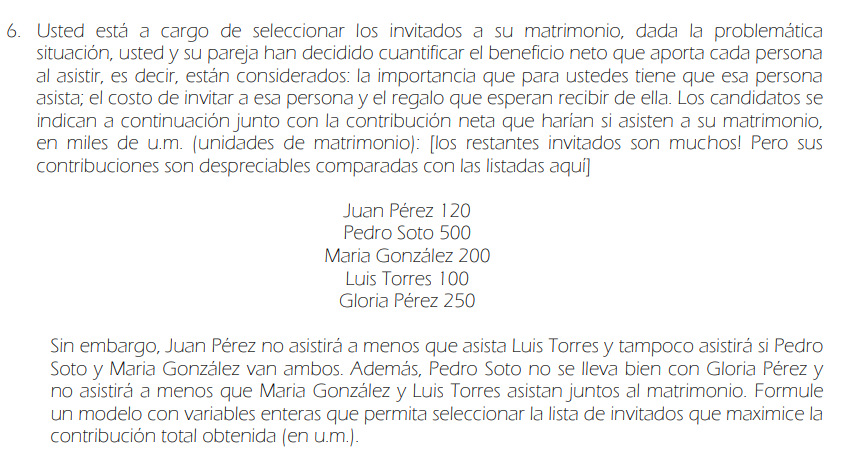

In [ ]:
%%ampl_eval
reset; # clear previous definitions
# define the setS

set PERSONAS;

# define parameters

#cONTRIBUCIÓN DE LAS PERSONAS
param contribu{PERSONAS};

#define variables

# Cantidad de dispositivos por personas
var invitados{PERSONAS} binary;

#define objective
# maximizar la cantidad de satisfacción
maximize satisfaccion: sum{per in PERSONAS} invitados[per]*contribu[per];

#define constraints

#Una personas no puede llevar mas de dos dispositivos (Restricción de demanda)
subject to juan_perez1:

#La compra de los dispositivos no puede superar el presupuesto
subject to lim_pesos: sum{per in PERSONAS, disp in DISPOSITIVOS} cant_disp[per, disp]*cost_disp[disp] <= pres_glob;

## Modelo 7

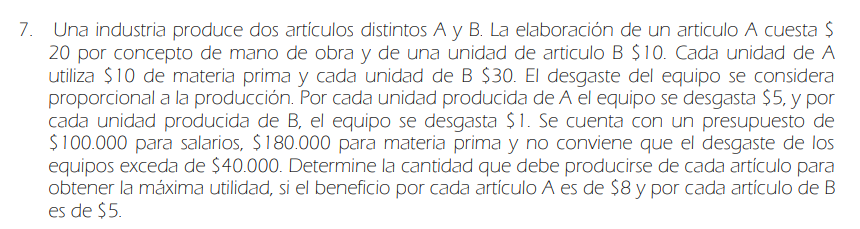

In [ ]:
%%ampl_eval
reset; # clear previous definitions
# define the setS

set

# Modelos 2do Corte

## Set Covering Location Model

In [ ]:
%%ampl_eval
reset; # clear previous definitions
# define the setS

set LOCALIDAD; #Posibles localizaciones
set DEMANDA; #Nodos de demanda

# define parameters

param dist_max; #Numero de la distancia maxima para que un nodo de demanda cubra las localidades
param cxl{LOCALIDAD};
param cyl{LOCALIDAD};
param cxd{DEMANDA};
param cyd{DEMANDA};
param distancias{l in LOCALIDAD, d in DEMANDA} = ((cxl[l]-cxd[d])^2 + (cyl[l]-cyd[d])^2)^(1/2); #Distancia entre las localidades y el nodo de demanda

# define subsets

set sub_demanda{d in DEMANDA} = {l in LOCALIDAD: distancias[l,d] <= dist_max}; #Sub conjunto de localizaciones l \in LOCALIDAD para atender al nodo de demanda d \in DEMANDA tal que distancias[l, d] < dist_max
  # check {d in DEMANDA, l in sub_demanda[d]}: distancias[l, d] <= dist_max;

# define the decision variables:
# X
var X{LOCALIDAD} binary; #Uno cuando la localización se abre, cero lo contrario

# the objective is to minimize total budget
minimize total_locality: sum{l in LOCALIDAD} X[l];

# constraint:
# Todo nodo de demanda debe estar cubierto por almenos una localidad
subject to demand_location {d in DEMANDA}: sum{l in sub_demanda[d]} X[l] >= 1;


In [ ]:
import pandas as pd
from random import randrange

taml, tamd = 20, 50
ampl.set["LOCALIDAD"] = [i+1 for i in range(taml)]
ampl.set["DEMANDA"] = [i+1 for i in range(tamd)]

ampl.param["dist_max"] = 30

y_d = [33.36,84.98,4.84,81.6,70.36,56.96,70.5,4.38,59.23,24.07,62.36,9.29,72.38,26.73,92.41,77.19,20.86,59.96,50.89,33.08,31.84,25.43,19.51,24.09,98.16,28.38,76.05,90.43,98.12,12.91,73.25,62.38,16.57,56.57,70.99,57.84,8.74,82.84,35.88,68.53,6.71,44.55,47.68,62.88,66.04,44.27,40.16,55.67,3.56,36.85]
x_d = [94.9,19.59,89.69,98.95,50.88,50.14,51.41,83.3,66.89,36.65,28.37,33,79.56,82.56,65.37,80.9,7.01,83.68,40.02,74.85,60.8,56.72,21.13,3.97,41.3,64.11,61.04,20.02,26.76,91.78,78.54,21.15,0.54,23.47,34.59,27.6,50.59,15.77,30.33,11.93,82.05,84.87,51.11,49.27,65.94,87.77,39.49,77.34,47.84,1.05]
y_l = [24.89,35.58,82.91,89.71,80.46,2.69,89.97,36.92,15.77,31.75,53.89,43.23,77.03,99.32,23.79,99.39,66.33,97.28,78.97,16.09]
x_l = [36.71,20.81,95.17,99.23,83.74,13.91,67,13.06,43.13,18.43,87.55,64.35,19.66,44.06,24.74,67.48,50.92,42.46,31.97,90.85]

distancia_localidad = [(x_l[i], y_l[i]) for i in range(taml)]
distancia_demanda = [(x_d[i], y_d[i]) for i in range(tamd)]

ampl.param["cxl"] = [distancia_localidad[i][0] for i in range(taml)]
ampl.param["cyl"] = [distancia_localidad[i][1] for i in range(taml)]
ampl.param["cxd"] = [distancia_demanda[i][0] for i in range(tamd)]
ampl.param["cyd"] = [distancia_demanda[i][1] for i in range(tamd)]

In [ ]:
ampl.option["solver"] = "gurobi"
ampl.solve()

solution = ampl.get_data("{l in LOCALIDAD: X[l] >= 0} X[l]").to_dict()

print("\nTo minimize the total location:")
for key in solution:
    print(f"- state {key}: {solution[key]}.")

Gurobi 11.0.1: Gurobi 11.0.1: optimal solution; objective 5
0 simplex iterations

To minimize the total location:
- state 1: 1.
- state 2: 0.
- state 3: 0.
- state 4: 0.
- state 5: 1.
- state 6: 0.
- state 7: 0.
- state 8: 0.
- state 9: 0.
- state 10: 0.
- state 11: 0.
- state 12: 0.
- state 13: 0.
- state 14: 0.
- state 15: 1.
- state 16: 0.
- state 17: 0.
- state 18: 0.
- state 19: 1.
- state 20: 1.


# Modulo 3

## Ejemplo

In [ ]:
%%ampl_eval
reset; # limpiar definiciones anteriores
# definir el conjunto de distribuidoras
set DIS;

# definir el conjunto de detallista
set DET;

# definir la demanda minima de los detallistas
param dem_min{DET};

# definir la disponibilidad maxima de los centros de distribución
param disp_dist{DIS};

#definir costo de transporte por unidad entre las distribuioras a los detallistas
param cost{DIS, DET};


# definir las variables de decision:
# x[E,S] acantidad de producto a producir desde la planta
var x{DIS, DET} >= 0;

# La función objetivo es minimizar el costo
minimize min_costo: sum{dis in DIS, det in DET} x[dis,det]*cost[dis,det];

# restricciones:

subject to no_exceder_disp {dis in DIS}: sum{det in DET} x[dis,det]  <= disp_dist[dis];

subject to cumplimiento_dist {det in DET}: sum{dis in DIS} x[dis,det] >= dem_min[det];



In [ ]:
import pandas as pd
ampl.set["DIS"] = ["Bogota", "Medellin", "Cali"]
ampl.set["DET"] = ["Pereira", "Tulua", "Anserma", "Ibague", "Armenia"]

ampl.param["dem_min"] = {"Pereira":25, "Tulua":10, "Anserma":20, "Ibague":30, "Armenia":15}
ampl.param["disp_dist"] = {"Bogota":20, "Medellin":50, "Cali":40}

cost_pd = pd.DataFrame(
    {"Pereira":[55, 35, 40],
     "Tulua":[30, 30, 60],
     "Anserma":[40, 100, 95],
     "Ibague":[50, 45, 35],
     "Armenia":[40, 60, 30]},
    ["Bogota", "Medellin", "Cali"]
)

print(cost_pd)
ampl.param["cost"] = cost_pd

          Pereira  Tulua  Anserma  Ibague  Armenia
Bogota         55     30       40      50       40
Medellin       35     30      100      45       60
Cali           40     60       95      35       30


In [ ]:
ampl.option["solver"] = "cbc"
ampl.solve()

solution = ampl.get_data("{dis in DIS, det in DET: x[dis, det] > 0} x[dis, det]").to_dict()

print("\nTo minimize the total cost:")
for dis, det in solution:
    key = (dis, det)
    print(f"Distribuidora {dis} envia al detallista {det} la cantidad de: {solution[key]} unidades.")

cbc 2.10.10: cbc 2.10.10: optimal solution; objective 3525
0 simplex iterations

To minimize the total cost:
Distribuidora Bogota envia al detallista Anserma la cantidad de: 20 unidades.
Distribuidora Cali envia al detallista Armenia la cantidad de: 15 unidades.
Distribuidora Cali envia al detallista Ibague la cantidad de: 25 unidades.
Distribuidora Medellin envia al detallista Ibague la cantidad de: 5 unidades.
Distribuidora Medellin envia al detallista Pereira la cantidad de: 25 unidades.
Distribuidora Medellin envia al detallista Tulua la cantidad de: 10 unidades.


In [ ]:
%%ampl_eval
solve;

display {j in 1.._nvars}
(_varname[j],_var[j],_var[j].rc, _var[j].lb,_var[j].ub);

display {i in 1.._ncons}
(_conname[i],_con[i].body, _con[i].dual, _con[i].slack, _con[i].lb, _con[i].ub);

cbc 2.10.10: cbc 2.10.10: optimal solution; objective 3525
0 simplex iterations
:           _varname[j]        _var[j] _var[j].rc _var[j].lb _var[j].ub    :=
1    "x['Bogota','Pereira']"       0        20         0       Infinity
2    "x['Bogota','Tulua']"         0         0         0       Infinity
3    "x['Bogota','Anserma']"      20         0         0       Infinity
4    "x['Bogota','Ibague']"        0         5         0       Infinity
5    "x['Bogota','Armenia']"       0         0         0       Infinity
6    "x['Medellin','Pereira']"    25         0         0       Infinity
7    "x['Medellin','Tulua']"      10         0         0       Infinity
8    "x['Medellin','Anserma']"     0        60         0       Infinity
9    "x['Medellin','Ibague']"      5         0         0       Infinity
10   "x['Medellin','Armenia']"     0        20         0       Infinity
11   "x['Cali','Pereira']"         0        15         0       Infinity
12   "x['Cali','Tulua']"           0 

## Ejemplo 2

In [ ]:
%%ampl_eval
reset; # limpiar definiciones anteriores
# definir el conjunto de distribuidoras
set DIS;

# definir el conjunto de detallista
set DET;

# definir la demanda minima de los detallistas
param dem_min{DET};

# definir la disponibilidad maxima de los centros de distribución
param disp_dist{DIS};

#definir costo de transporte por unidad entre las distribuioras a los detallistas
param cost{DIS, DET};


# definir las variables de decision:
# x[E,S] acantidad de producto a producir desde la planta
var x{DIS, DET} >= 0;

# La función objetivo es minimizar el costo
minimize min_costo: sum{dis in DIS, det in DET} x[dis,det]*cost[dis,det];

# restricciones:

subject to no_exceder_disp {dis in DIS}: sum{det in DET} x[dis,det]  <= disp_dist[dis];

subject to cumplimiento_dist {det in DET}: sum{dis in DIS} x[dis,det] >= dem_min[det];

In [ ]:
import pandas as pd
ampl.set["DIS"] = ["Bogota", "Medellin", "Cali"]
ampl.set["DET"] = ["Pereira", "Tulua", "Anserma", "Ibague", "Armenia"]

ampl.param["dem_min"] = {"Pereira":25, "Tulua":10, "Anserma":20, "Ibague":30, "Armenia":15}
ampl.param["disp_dist"] = {"Bogota":20, "Medellin":50, "Cali":40}

cost_pd = pd.DataFrame(
    {"Pereira":[55, 35, 40],
     "Tulua":[30, 30, 60],
     "Anserma":[40, 100, 95],
     "Ibague":[50, 45, 35],
     "Armenia":[40, 60, 30]},
    ["Bogota", "Medellin", "Cali"]
)

print(cost_pd)
ampl.param["cost"] = cost_pd

          Pereira  Tulua  Anserma  Ibague  Armenia
Bogota         55     30       40      50       40
Medellin       35     30      100      45       60
Cali           40     60       95      35       30


In [ ]:
ampl.option["solver"] = "cbc"
ampl.solve()

solution = ampl.get_data("{dis in DIS, det in DET: x[dis, det] > 0} x[dis, det]").to_dict()

print("\nTo minimize the total cost:")
for dis, det in solution:
    key = (dis, det)
    print(f"Distribuidora {dis} envia al detallista {det} la cantidad de: {solution[key]} unidades.")

cbc 2.10.10: cbc 2.10.10: optimal solution; objective 3525
0 simplex iterations

To minimize the total cost:
Distribuidora Bogota envia al detallista Anserma la cantidad de: 20 unidades.
Distribuidora Cali envia al detallista Armenia la cantidad de: 15 unidades.
Distribuidora Cali envia al detallista Ibague la cantidad de: 25 unidades.
Distribuidora Medellin envia al detallista Ibague la cantidad de: 5 unidades.
Distribuidora Medellin envia al detallista Pereira la cantidad de: 25 unidades.
Distribuidora Medellin envia al detallista Tulua la cantidad de: 10 unidades.


In [ ]:
%%ampl_eval
solve;

display {j in 1.._nvars}
(_varname[j],_var[j],_var[j].rc, _var[j].lb,_var[j].ub);

display {i in 1.._ncons}
(_conname[i],_con[i].body, _con[i].dual, _con[i].slack, _con[i].lb, _con[i].ub);

cbc 2.10.10: cbc 2.10.10: optimal solution; objective 3525
0 simplex iterations
:           _varname[j]        _var[j] _var[j].rc _var[j].lb _var[j].ub    :=
1    "x['Bogota','Pereira']"       0        20         0       Infinity
2    "x['Bogota','Tulua']"         0         0         0       Infinity
3    "x['Bogota','Anserma']"      20         0         0       Infinity
4    "x['Bogota','Ibague']"        0         5         0       Infinity
5    "x['Bogota','Armenia']"       0         0         0       Infinity
6    "x['Medellin','Pereira']"    25         0         0       Infinity
7    "x['Medellin','Tulua']"      10         0         0       Infinity
8    "x['Medellin','Anserma']"     0        60         0       Infinity
9    "x['Medellin','Ibague']"      5         0         0       Infinity
10   "x['Medellin','Armenia']"     0        20         0       Infinity
11   "x['Cali','Pereira']"         0        15         0       Infinity
12   "x['Cali','Tulua']"           0 